In [42]:
! pip install pandas
! pip install matplotlib
! pip install seaborn
! pip install numpy
! pip install transformers
! pip install sentence_transformers
! pip install torch torchvision torchaudio

In [43]:
import pandas as pd
import datetime
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import semantic_search
from IPython.display import display, Markdown


In [44]:
runway=pd.read_csv('runway.csv',parse_dates=['review_date'])
print(runway.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1506 entries, 0 to 1505
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      1506 non-null   int64         
 1   item_id      1506 non-null   int64         
 2   rating       1506 non-null   int64         
 3   rented for   1506 non-null   object        
 4   review_text  1506 non-null   object        
 5   category     1506 non-null   object        
 6   height       1503 non-null   object        
 7   size         1506 non-null   int64         
 8   age          1500 non-null   float64       
 9   review_date  1506 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 117.8+ KB
None


In [45]:
runway.head()

,user_id,item_id,rating,rented for,review_text,category,height,size,age,review_date
0,476109,139086,8,formal affair,it hit the floor perfectly with a pair of heel...,gown,"5' 3""",15,27.0,2017-12-19
1,203660,1126889,6,party,the dress is absolutely gorgeous unfortunately...,dress,"5' 4""",12,28.0,2022-01-03
2,868581,652189,8,wedding,even though it was lined with satin this was a...,dress,"5' 5""",24,30.0,2021-08-05
3,935076,1879504,8,wedding,this dress was greatit fit really well and was...,sheath,"5' 3""",14,37.0,2021-10-02
4,995023,1179146,10,party,super flattering i am usually a sizemi have a ...,dress,"5' 2""",14,37.0,2022-11-20


Preprocessing the 'review_text'


In [46]:
def clean_text(dataframe,column_name):
    dataframe[column_name]=dataframe[column_name].str.replace(r'\/' , "")
    dataframe[column_name]=dataframe[column_name].str.translate(string.punctuation)
    dataframe[column_name] = dataframe[column_name].str.replace(r"\d+", "")
    dataframe[column_name]=dataframe[column_name].str.replace(r'\s{2,}' , "")
    dataframe[column_name]=dataframe[column_name].str.lower()
    return dataframe


clean_text(runway,'review_text')

C:\Users\osmnc\AppData\Local\Temp\ipykernel_12496\4039378247.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe[column_name]=dataframe[column_name].str.replace(r'\/' , "")
C:\Users\osmnc\AppData\Local\Temp\ipykernel_12496\4039378247.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe[column_name] = dataframe[column_name].str.replace(r"\d+", "")
C:\Users\osmnc\AppData\Local\Temp\ipykernel_12496\4039378247.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe[column_name]=dataframe[column_name].str.replace(r'\s{2,}' , "")


,user_id,item_id,rating,rented for,review_text,category,height,size,age,review_date
0,476109,139086,8,formal affair,it hit the floor perfectly with a pair of heel...,gown,"5' 3""",15,27.0,2017-12-19
1,203660,1126889,6,party,the dress is absolutely gorgeous unfortunately...,dress,"5' 4""",12,28.0,2022-01-03
2,868581,652189,8,wedding,even though it was lined with satin this was a...,dress,"5' 5""",24,30.0,2021-08-05
3,935076,1879504,8,wedding,this dress was greatit fit really well and was...,sheath,"5' 3""",14,37.0,2021-10-02
4,995023,1179146,10,party,super flattering i am usually a sizemi have a ...,dress,"5' 2""",14,37.0,2022-11-20
...,...,...,...,...,...,...,...,...,...,...
1501,832517,640839,10,wedding,i loved this dress it was so beautiful and rec...,dress,"5' 5""",1,31.0,2022-04-30
1502,64179,154002,8,formal affair,this dress was perfect i couldnt have loved it...,gown,"5' 5""",8,34.0,2018-06-12
1503,235056,1112658,8,wedding,this dress fits like a glove and the fabric is...,dress,"5' 4""",8,31.0,2020-09-18
1504,866301,985087,10,formal affair,i wore this dress for prom i absolutely loved ...,gown,"5' 4""",16,17.0,2021-08-22


In [47]:
runway['review_text']

0       it hit the floor perfectly with a pair of heel...
1       the dress is absolutely gorgeous unfortunately...
2       even though it was lined with satin this was a...
3       this dress was greatit fit really well and was...
4       super flattering i am usually a sizemi have a ...
                              ...                        
1501    i loved this dress it was so beautiful and rec...
1502    this dress was perfect i couldnt have loved it...
1503    this dress fits like a glove and the fabric is...
1504    i wore this dress for prom i absolutely loved ...
1505               fit just a bit small i usually wear a 
Name: review_text, Length: 1506, dtype: object

Sentiment Analysis on 'review_text_cleaned'

In [48]:
model='distilbert-base-uncased-finetuned-sst-2-english'

sentimentAnalysis=pipeline('sentiment-analysis',model=model)
sent_analysis_output=sentimentAnalysis(list(runway['review_text']))

Histogram of Sentiment Score

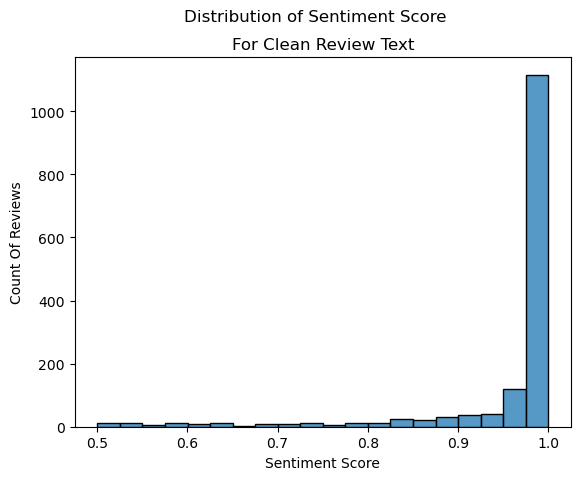

In [49]:
runway['clean_sentiment_category']=[s['label']for s in sent_analysis_output]
runway['clean_sentiment_score']=[s['score']for s in sent_analysis_output]


sns.histplot(data=runway, x='clean_sentiment_score',bins=20)
plt.suptitle('Distribution of Sentiment Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Count Of Reviews')
plt.title('For Clean Review Text')
plt.show()

Sentiment Over the Years

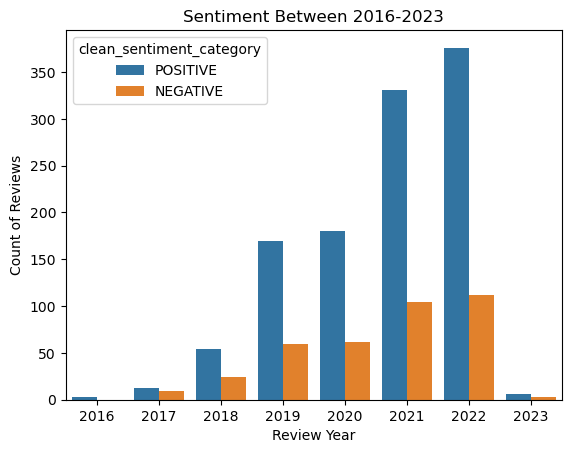

In [50]:
runway['year']=runway['review_date'].dt.year

chart_data=runway.groupby(['year','clean_sentiment_category'] , as_index=False)['user_id'].count()
chart_data.columns=['year','clean_sentiment_category','cnt']

sns.barplot(data=chart_data, x='year', y='cnt', hue='clean_sentiment_category',errorbar=None)
plt.title('Sentiment Between 2016-2023')
plt.xlabel('Review Year')
plt.ylabel('Count of Reviews')
plt.show()

In [51]:
sent_analysis_2=sentimentAnalysis(list(runway['review_text']))
runway['sentiment_category']=[s['label'] for s in sent_analysis_2]
runway['sentiment_score']=[s['score'] for s in sent_analysis_2]

display(pd.crosstab(runway['clean_sentiment_category'], runway['sentiment_category']))


sentiment_category,NEGATIVE,POSITIVE
clean_sentiment_category,,
NEGATIVE,374,0
POSITIVE,0,1132


Embeddings

In [59]:
model_id = "sentence-transformers/all-MiniLM-L6-v2"

# Instantiate a new SentenceTransformer object.
model = SentenceTransformer(model_id)

# Generate the embeddings for the "rented for" column.
embeddings = model.encode(list(runway["rented for"]))

print(embeddings.shape)

(1506, 384)


Clustering

In [60]:
from sklearn.manifold import TSNE

tsne=TSNE(n_components=2,perplexity=15,random_state=42,init='random',learning_rate=200)
tsne_dims=tsne.fit_transform(embeddings)
print(tsne_dims.shape)

(1506, 2)


Visualizing the Clusters

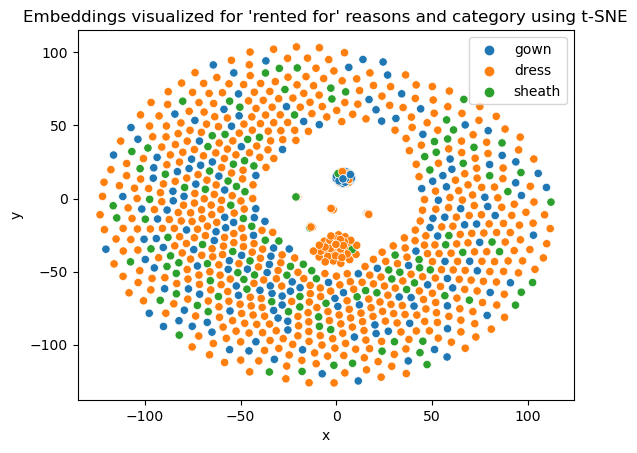

In [61]:
# Parse out the x and y dimensions from the tsne output.
runway['x'] = [x for x,y in tsne_dims]
runway['y'] = [y for x,y in tsne_dims]

# Create the scatterplot
sns.scatterplot(x = "x", y = "y", hue = "category", data = runway)
plt.legend()
plt.title("Embeddings visualized for 'rented for' reasons and category using t-SNE")
plt.show()

Semantic Search

In [69]:
query='a beautiful and elegant gown'
query_emb=model.encode(query, convert_to_tensor=True)
hits=semantic_search(query_emb,embeddings,top_k=3)


for hit in hits[0]:
    idx=hit['corpus_id']
    print(
        "ITEM ID: ", runway.iloc[idx]['item_id'], 
        "; RENTED FOR: ", runway.iloc[idx]['rented for'],
        "; REVIEW", runway.iloc[idx]['review_text'])

    

ITEM ID:  652189 ; RENTED FOR:  wedding ; REVIEW even though it was lined with satin this was a light beachy dress that was still formal enough for this casual beach weddingitsbackless though so you cant wear a bra and because the neck is such a scoopneck it makes the neckline a little strange if you have a chest and dont wear onei ended up getting one of those stick on bras and the dress looked much betterits much pinker than the model picture which was a pleasant surprisepretty dress comfortable just a little awkward fitting in the chest area if you have anything larger than an abuy the stick on bra
ITEM ID:  1498329 ; RENTED FOR:  wedding ; REVIEW the dress was gorgeous but unfortunately i was unable to wear it due to some quality issues which the renttherunway team was excellent at handlingi would recommend going upsizes from your usual dress size if you have a larger bustit also runs on the long side imand even withinch heels it dragged a little too much for my preferencethe colou

Generate New Marketing Material

In [73]:
generator=pipeline(model='gpt2')
prompt = "Upgrade your wardrobe with the latest dresses of the season and"
output=generator(prompt,num_return_sequences=1, return_full_text=False)
print('New Marketing Campaign ', prompt,output[0]['generated_text'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


New Marketing Campaign  Upgrade your wardrobe with the latest dresses of the season and  take your wardrobe up a few more steps toward the top or bottom of the list! Learn more…
